In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv


In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set_theme(style = "whitegrid")

import warnings

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay

In [3]:
df = pd.read_csv("../input/loan-prediction-based-on-customer-behavior/Training Data.csv")
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [4]:
df.shape

(252000, 13)

In [5]:
df.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [6]:
df.dtypes

Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [7]:
df.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


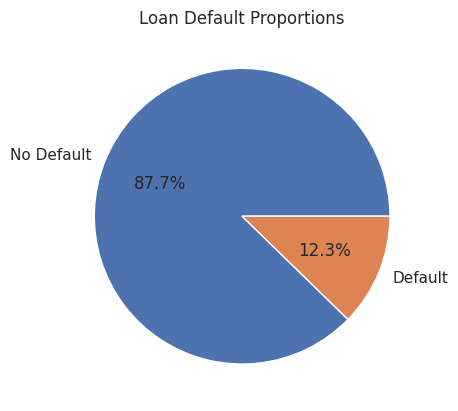

In [8]:
proportions = df['Risk_Flag'].value_counts()
labels = proportions.index.map({0: 'No Default', 1: 'Default'})

plt.pie(proportions, labels=labels, autopct='%.1f%%')  
plt.title('Loan Default Proportions')
plt.show() 

The dataset is imbalanced; about 88% are negative samples. When we do training, validation and test splits, data balancing may be required.

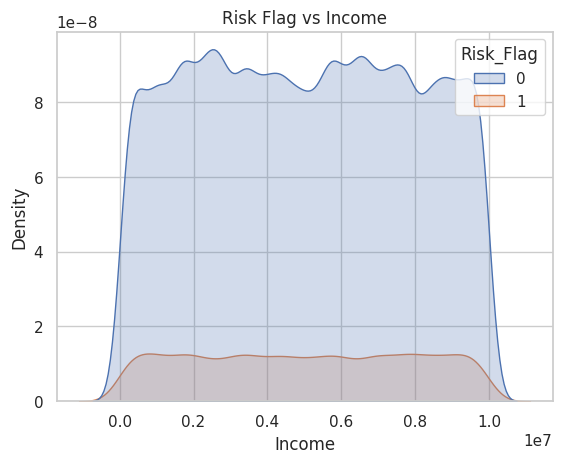

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(data=df, x='Income', hue='Risk_Flag', fill=True)
    plt.title("Risk Flag vs Income")
    plt.show()

'Income' alone doesn't necessarily determine whether or not someone defaults on loan.

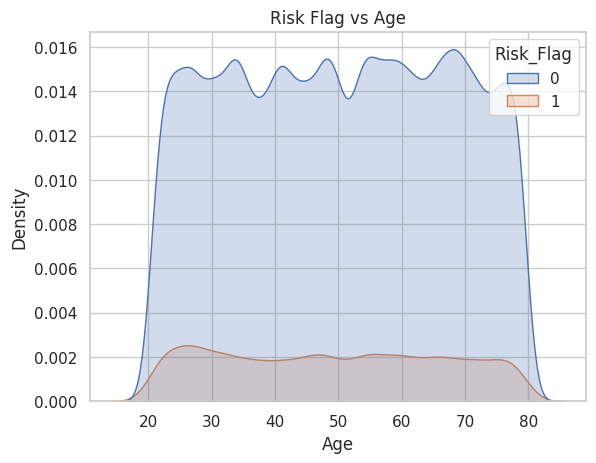

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(data=df, x='Age', hue='Risk_Flag', fill=True)
    plt.title("Risk Flag vs Age")
    plt.show()

Young people (in early twenties to thirty) have higher ratio of loan defaults.

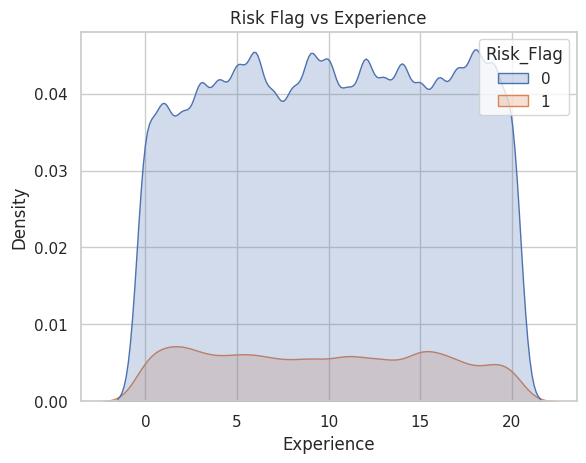

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(data=df, x='Experience', hue='Risk_Flag', fill=True)
    plt.title("Risk Flag vs Experience")
    plt.show()

People with the least years of professional experience have higher ratio of loan defaults.
People with the most years of professional experience have lower ratio of loan defaults.

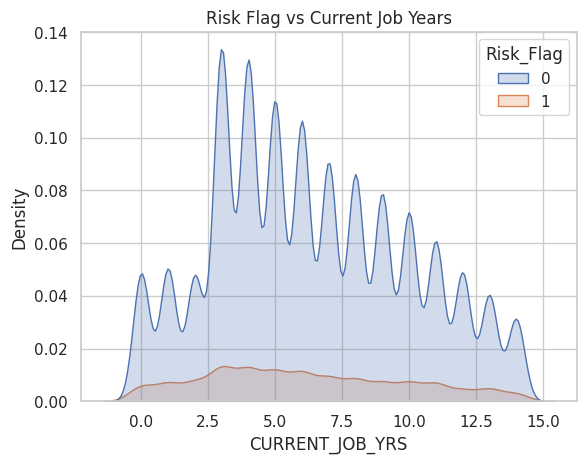

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(data=df, x='CURRENT_JOB_YRS', hue='Risk_Flag', fill=True)
    plt.title("Risk Flag vs Current Job Years")
    plt.show()

Borrowers who are not very long in their current jobs (0 up to 2.5 years) have higher ratio of loan defaults.

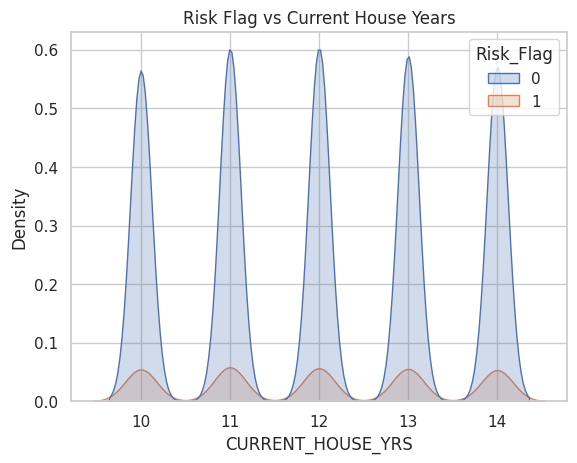

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.kdeplot(data=df, x='CURRENT_HOUSE_YRS', hue='Risk_Flag', fill=True)
    plt.title("Risk Flag vs Current House Years")
    plt.show()

The number of years in current house doesn't necessarily determine whether or not someone defaults on loan.

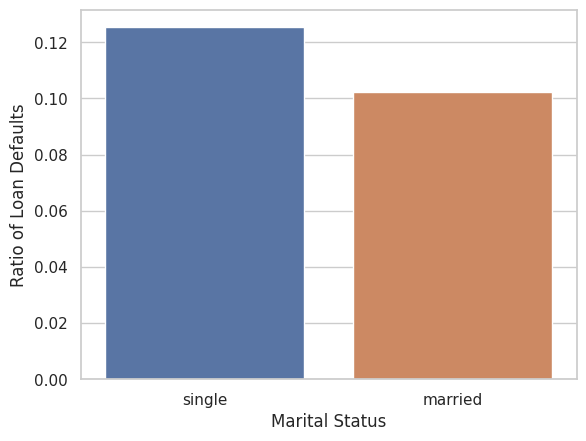

In [14]:
default_ratio_by_marital_status = df.groupby('Married/Single').Risk_Flag.mean().sort_values(ascending=False)
ax = sns.barplot(x=default_ratio_by_marital_status.index,
                 y=default_ratio_by_marital_status)
ax.set(xlabel='Marital Status', ylabel='Ratio of Loan Defaults')
plt.show()

Among the borrowers, 'single' people have higher chance of defaulting loans than 'married' people.

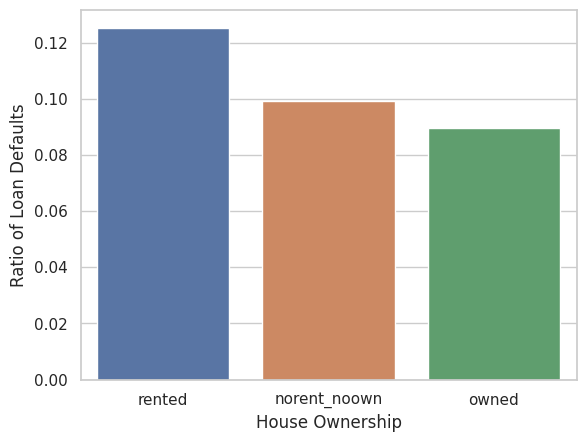

In [15]:
default_ratio_by_house_ownership = df.groupby('House_Ownership').Risk_Flag.mean().sort_values(ascending=False)
ax = sns.barplot(x=default_ratio_by_house_ownership.index,
                 y=default_ratio_by_house_ownership)
ax.set(xlabel='House Ownership', ylabel='Ratio of Loan Defaults')
plt.show()

Among the borrowers, people who live in rental properties have the highest chance of defaulting loans.

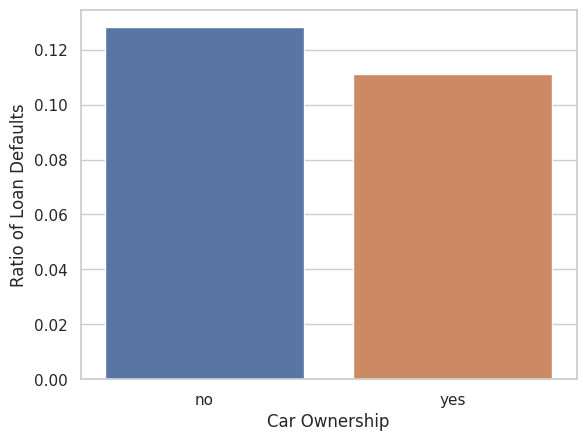

In [16]:
default_ratio_by_car_ownership = df.groupby('Car_Ownership').Risk_Flag.mean().sort_values(ascending=False)
ax = sns.barplot(x=default_ratio_by_car_ownership.index,
                 y=default_ratio_by_car_ownership)
ax.set(xlabel='Car Ownership', ylabel='Ratio of Loan Defaults')
plt.show()

Among the borrowers, people without cars have higher chance of defaulting loans than those who own cars.

In [17]:
df.groupby('Profession').Risk_Flag.mean().sort_values(ascending=False)

Profession
Police_officer                0.164052
Chartered_Accountant          0.153572
Army_officer                  0.152113
Surveyor                      0.151464
Software_Developer            0.148427
Scientist                     0.144321
Geologist                     0.144264
Civil_engineer                0.135832
Official                      0.135796
Firefighter                   0.135789
Air_traffic_controller        0.135391
Hotel_Manager                 0.135380
Aviator                       0.134931
Technical_writer              0.134167
Architect                     0.131200
Secretary                     0.130409
Lawyer                        0.129514
Computer_hardware_engineer    0.128444
Technician                    0.128289
Biomedical_Engineer           0.127560
Consultant                    0.125208
Microbiologist                0.124360
Computer_operator             0.124048
Flight_attendant              0.123635
Artist                        0.122609
Psychologist  

The list above shows 'Professions' sorted by 'Loan Default Ratios' (highest to lowest).

In [18]:
with pd.option_context('display.max_rows', None):
  display(df.groupby('CITY').Risk_Flag.mean().sort_values(ascending=False))

CITY
Bhubaneswar                     0.326194
Gwalior                         0.272727
Bettiah[33]                     0.266958
Kochi                           0.252862
Raiganj                         0.239554
Purnia[26]                      0.238866
Barasat                         0.238702
Sikar                           0.238452
Buxar[37]                       0.231472
Satna                           0.225681
Kottayam                        0.225369
Kavali                          0.225061
Mysore[7][8][9]                 0.220568
Bardhaman                       0.219158
Gandhidham                      0.216467
Imphal                          0.215548
Ghaziabad                       0.208733
Ramagundam[27]                  0.208447
Muzaffarnagar                   0.208084
Ahmedabad                       0.204931
Munger                          0.204651
Mathura                         0.203343
Thiruvananthapuram              0.203333
Hazaribagh                      0.202091
Guntur[13] 

The list above shows 'Cities' sorted by 'Loan Default Ratios' (highest to lowest).

In [19]:
df.groupby('STATE').Risk_Flag.mean().sort_values(ascending=False)

STATE
Manipur              0.215548
Tripura              0.168109
Kerala               0.167097
Jammu_and_Kashmir    0.158989
Madhya_Pradesh       0.154369
Odisha               0.142550
Rajasthan            0.140833
Jharkhand            0.133296
Chhattisgarh         0.133281
Himachal_Pradesh     0.133253
Assam                0.131691
Bihar                0.130586
Uttar_Pradesh[5]     0.130552
Telangana            0.130117
West_Bengal          0.128135
Haryana              0.124208
Gujarat              0.117724
Uttar_Pradesh        0.117711
Puducherry           0.116539
Andhra_Pradesh       0.116022
Maharashtra          0.113254
Mizoram              0.110718
Delhi                0.104554
Tamil_Nadu           0.103163
Karnataka            0.100295
Chandigarh           0.092988
Punjab               0.090042
Uttarakhand          0.070971
Sikkim               0.046053
Name: Risk_Flag, dtype: float64

The list above shows 'States' sorted by 'Loan Default Ratios' (highest to lowest).

In [20]:
def data_distribution(train, test):    
    plt.hist([train, test])
    plt.legend(['Train', 'Test'])
    plt.xticks(ticks=[0,1], labels=['No Default', 'Default'])
    plt.ylabel('Count')
    plt.title("Distribution of Train and Test Sets")
    plt.show()

In [21]:
def print_evaluation(y_test, y_pred):
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("ROC AUC score:", roc_auc_score(y_test,y_pred))

In [22]:
X = df.drop(['Id', 'Risk_Flag'], axis=1)
y = df['Risk_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Separate data into the features and target, and split into train and test sets.

In [23]:
cols_to_target_encode = ['Profession', 'CITY', 'STATE']

for col in cols_to_target_encode:
    encoder = TargetEncoder()
    X_train[col] = encoder.fit_transform(X_train[col], y_train)
    X_test[col] = encoder.transform(X_test[col])

Categorical features, 'Profession', 'CITY' and 'STATE', are target encoded using 'Risk_Flag' target from the training set.

In [24]:
marital_status_dict = {'married': 1, 'single': 0}
car_ownership_dict = {'yes': 1, 'no': 0}

for dataset in [X_train, X_test]:    
    dataset['Married/Single'] = dataset['Married/Single'].map(marital_status_dict)
    dataset['Car_Ownership'] = dataset['Car_Ownership'].map(car_ownership_dict)

Categorical features, 'Married/Single' and 'Car_Ownership', are binary encoded.

In [25]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_cols = encoder.fit_transform(X_train[['House_Ownership']])
encoded_cols_df = pd.DataFrame(encoded_cols, 
                          columns = encoder.get_feature_names_out(['House_Ownership']))
X_train = pd.concat([X_train, encoded_cols_df.set_index(X_train.index)], axis=1)
X_train.drop('House_Ownership', axis=1, inplace=True)

encoded_cols = encoder.transform(X_test[['House_Ownership']])
encoded_cols_df = pd.DataFrame(encoded_cols, 
                          columns = encoder.get_feature_names_out(['House_Ownership']))
X_test = pd.concat([X_test, encoded_cols_df.set_index(X_test.index)], axis=1)
X_test.drop('House_Ownership', axis=1, inplace=True)

Categorical feature, 'House_Ownership', is one-hot encoded.

In [26]:
cols_to_scale = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Numerical features, 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', and 'CURRENT_HOUSE_YRS', are normalized.

In [27]:
X_train.head()

,Income,Age,Experience,Married/Single,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
200471,1.430422,1.170436,1.318759,0,0,0.120873,0.236842,0.139313,-0.914084,-0.712569,0.0,0.0,1.0
92611,-0.820701,-0.644922,-1.680840,0,0,0.128980,0.078621,0.103837,-1.736837,-0.712569,0.0,0.0,1.0
86397,-1.385148,-0.644922,-0.181041,0,0,0.131487,0.155722,0.128364,-0.639833,0.717243,0.0,0.0,1.0
110500,-0.383000,-1.699001,-1.347551,0,0,0.129292,0.192362,0.133547,-1.188335,0.002337,0.0,0.0,1.0
185133,1.551521,-0.527803,-0.847618,0,1,0.107390,0.114327,0.101142,-0.365582,0.717243,1.0,0.0,0.0


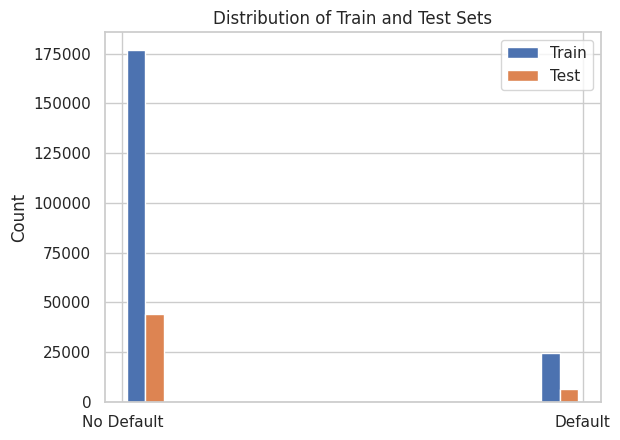

In [28]:
data_distribution(y_train, y_test)

In [29]:
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_train,y_train)

y_pred = model_1.predict(X_test)
print_evaluation(y_test, y_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     44147
           1       0.60      0.54      0.57      6253

    accuracy                           0.90     50400
   macro avg       0.77      0.74      0.75     50400
weighted avg       0.89      0.90      0.90     50400

Confusion Matrix
[[41937  2210]
 [ 2905  3348]]

ROC AUC score: 0.7426814851162876


In [30]:
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
X_test_us, y_test_us = rus.fit_resample(X_test, y_test)

Undersampling is done for the majority class to rebalance the dataset.

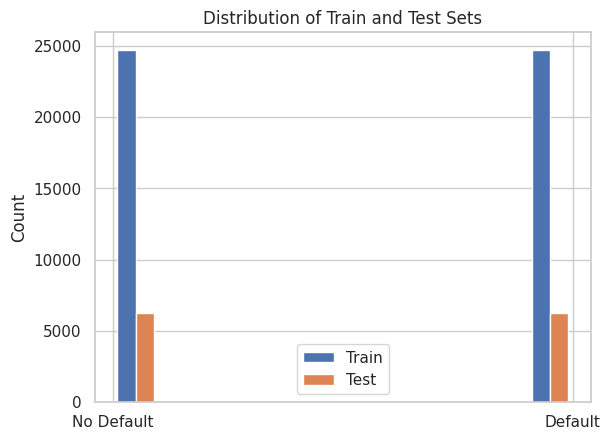

In [31]:
data_distribution(y_train_us, y_test_us)

In [32]:
model_2 = RandomForestClassifier(random_state=42)
model_2.fit(X_train_us,y_train_us)

y_pred_us = model_2.predict(X_test_us)
print_evaluation(y_test_us, y_pred_us)

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      6253
           1       0.88      0.81      0.84      6253

    accuracy                           0.85     12506
   macro avg       0.85      0.85      0.85     12506
weighted avg       0.85      0.85      0.85     12506

Confusion Matrix
[[5548  705]
 [1174 5079]]

ROC AUC score: 0.8497521189828883


In [33]:
smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)
X_test_os, y_test_os = smote.fit_resample(X_test, y_test)

Oversampling is done for the minority class to rebalance the dataset.

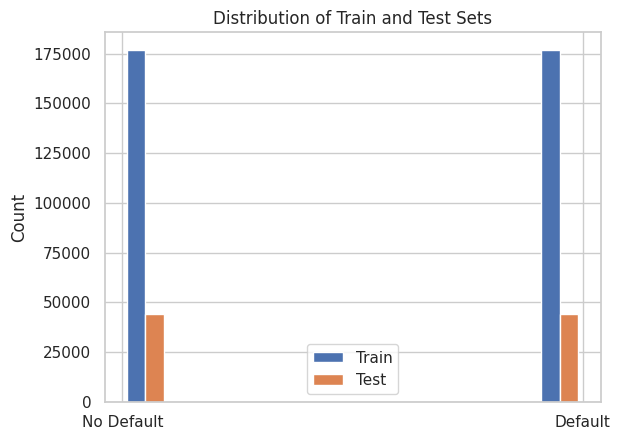

In [34]:
data_distribution(y_train_os, y_test_os)

In [35]:
model_3 = RandomForestClassifier(random_state=42)
model_3.fit(X_train_os,y_train_os)

y_pred_os = model_3.predict(X_test_os)
print_evaluation(y_test_os, y_pred_os)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     44147
           1       0.90      0.93      0.92     44147

    accuracy                           0.92     88294
   macro avg       0.92      0.92      0.92     88294
weighted avg       0.92      0.92      0.92     88294

Confusion Matrix
[[39731  4416]
 [ 2898 41249]]

ROC AUC score: 0.9171631141413912


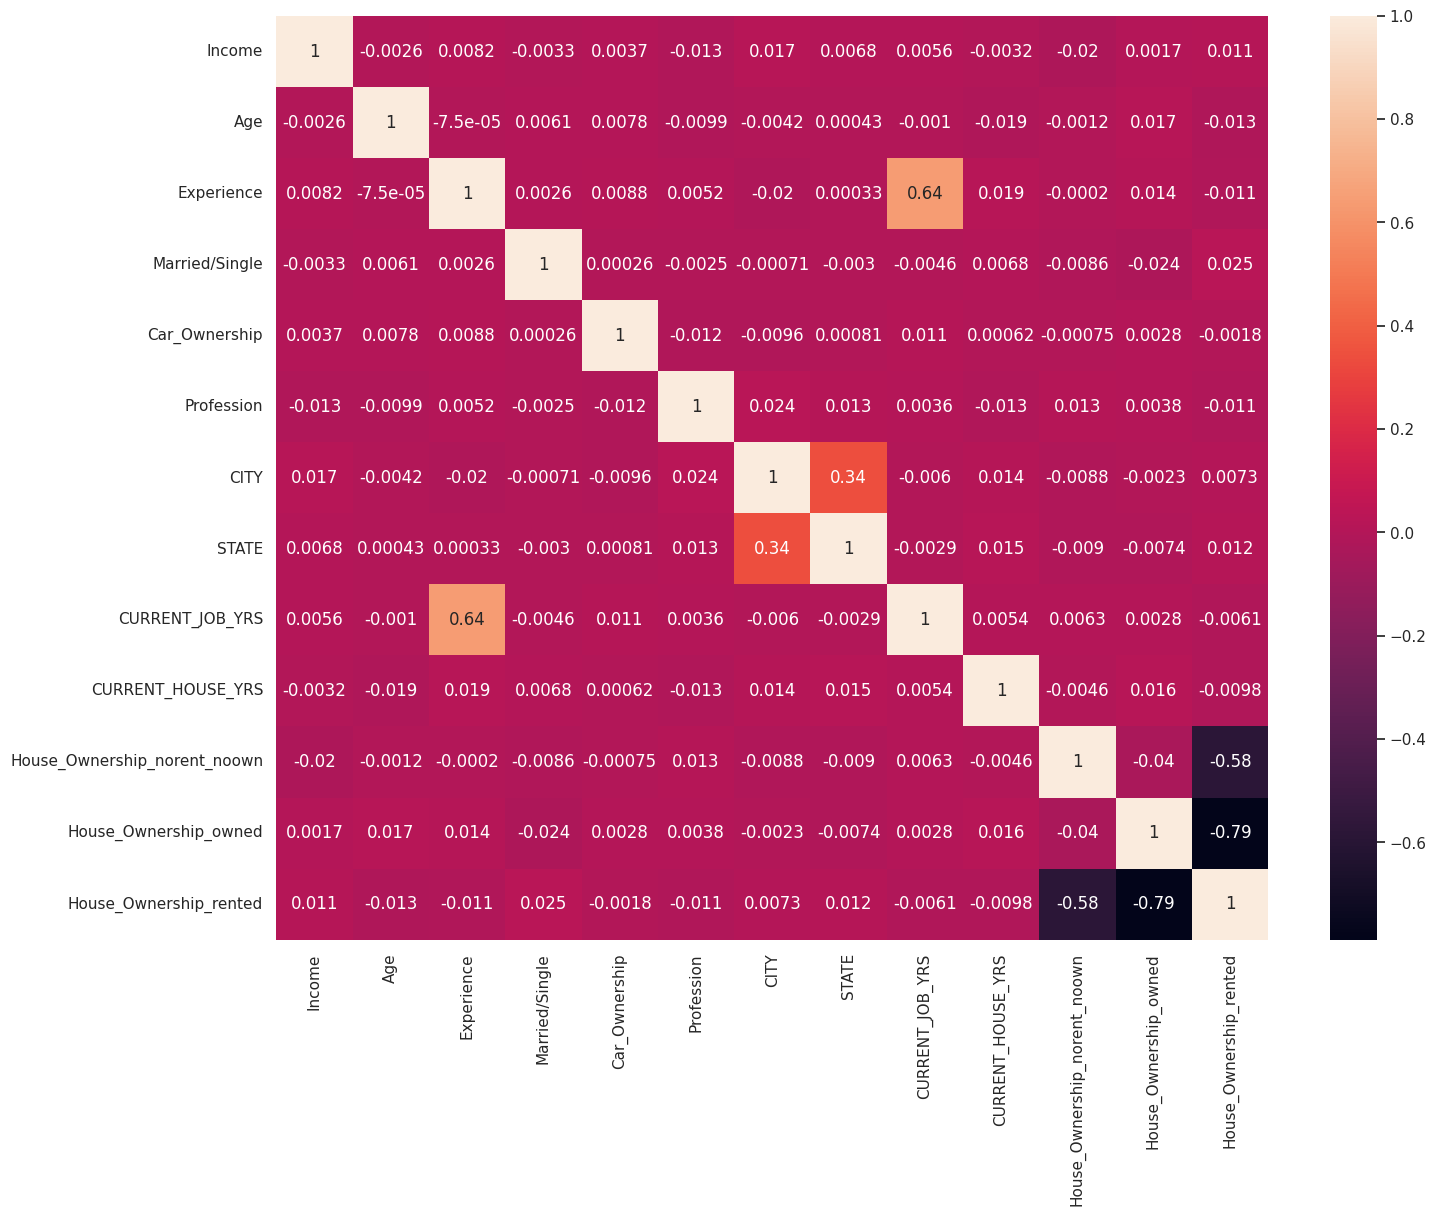

In [36]:
plt.figure(figsize=(16,12))
sns.heatmap(X_train.corr(method='spearman'), annot=True)
plt.show()

As we analyze the correlation of features, we find 'Experience' and 'CURRENT_JOB_YRS' to be highly correlated while 'STATE' and 'CITY' are somewhat correlated.

In [37]:
cols_to_drop = ['CURRENT_JOB_YRS', 'CITY']

X_train_reduced = X_train.drop(cols_to_drop, axis=1)
X_test_reduced = X_test.drop(cols_to_drop, axis=1)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train_reduced, y_train)
X_test_os, y_test_os = smote.fit_resample(X_test_reduced, y_test)

'CURRENT_JOB_YRS' and 'CITY' features are dropped.

In [38]:
X_train_reduced.head()

,Income,Age,Experience,Married/Single,Car_Ownership,Profession,STATE,CURRENT_HOUSE_YRS,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
200471,1.430422,1.170436,1.318759,0,0,0.120873,0.139313,-0.712569,0.0,0.0,1.0
92611,-0.820701,-0.644922,-1.680840,0,0,0.128980,0.103837,-0.712569,0.0,0.0,1.0
86397,-1.385148,-0.644922,-0.181041,0,0,0.131487,0.128364,0.717243,0.0,0.0,1.0
110500,-0.383000,-1.699001,-1.347551,0,0,0.129292,0.133547,0.002337,0.0,0.0,1.0
185133,1.551521,-0.527803,-0.847618,0,1,0.107390,0.101142,0.717243,1.0,0.0,0.0


In [39]:
model_4 = RandomForestClassifier(random_state=42)
model_4.fit(X_train_os,y_train_os)

y_pred_os = model_4.predict(X_test_os)
print_evaluation(y_test_os, y_pred_os)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     44147
           1       0.91      0.93      0.92     44147

    accuracy                           0.92     88294
   macro avg       0.92      0.92      0.92     88294
weighted avg       0.92      0.92      0.92     88294

Confusion Matrix
[[39957  4190]
 [ 3013 41134]]

ROC AUC score: 0.9184202777085645


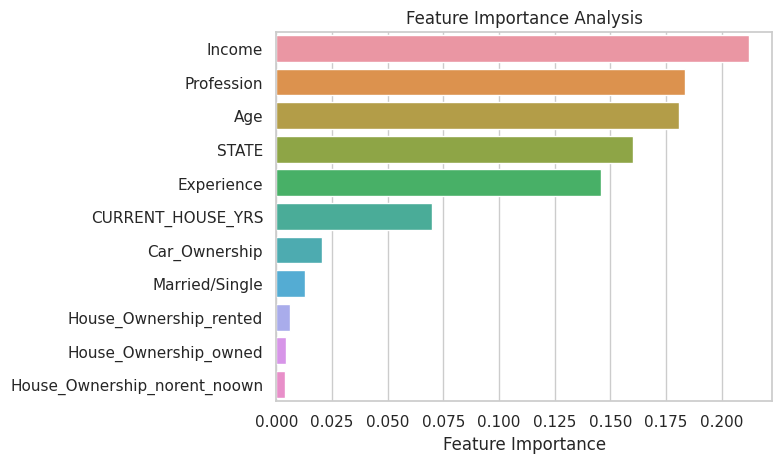

In [40]:
feature_imp = pd.DataFrame(index = X_train_reduced.columns, 
                           data = model_4.feature_importances_, 
                           columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)

ax = sns.barplot(x=feature_imp["Feature Importance"], y=feature_imp.index)
plt.title("Feature Importance Analysis")
plt.show()

From the feature importance analysis, we find 'Car_Ownership', 'Married/Single' and 'House_Ownership' have relatively low importance.

In [41]:
cols_to_drop = cols_to_drop + ['Car_Ownership', 'Married/Single', 
                               'House_Ownership_rented', 'House_Ownership_owned', 
                               'House_Ownership_norent_noown']

X_train_reduced = X_train.drop(cols_to_drop, axis=1)
X_test_reduced = X_test.drop(cols_to_drop, axis=1)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train_reduced, y_train)
X_test_os, y_test_os = smote.fit_resample(X_test_reduced, y_test)

Less important features are dropped.

In [42]:
X_train_reduced.head()

,Income,Age,Experience,Profession,STATE,CURRENT_HOUSE_YRS
200471,1.430422,1.170436,1.318759,0.120873,0.139313,-0.712569
92611,-0.820701,-0.644922,-1.680840,0.128980,0.103837,-0.712569
86397,-1.385148,-0.644922,-0.181041,0.131487,0.128364,0.717243
110500,-0.383000,-1.699001,-1.347551,0.129292,0.133547,0.002337
185133,1.551521,-0.527803,-0.847618,0.107390,0.101142,0.717243


In [43]:
model_5 = RandomForestClassifier(random_state=42)
model_5.fit(X_train_os,y_train_os)

y_pred_os = model_5.predict(X_test_os)
print_evaluation(y_test_os, y_pred_os)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     44147
           1       0.91      0.94      0.92     44147

    accuracy                           0.92     88294
   macro avg       0.92      0.92      0.92     88294
weighted avg       0.92      0.92      0.92     88294

Confusion Matrix
[[39963  4184]
 [ 2704 41443]]

ROC AUC score: 0.9219879040478401


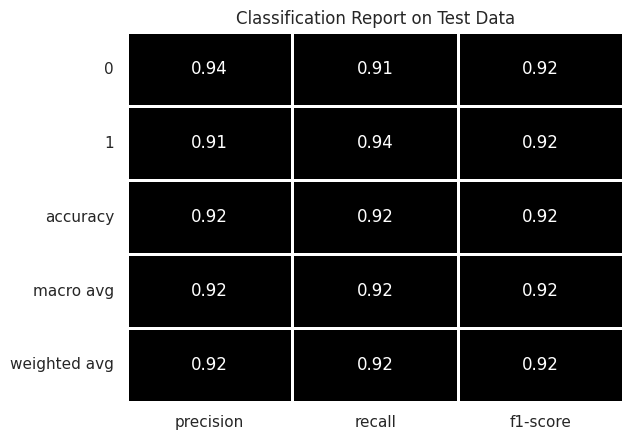

In [44]:
clf_report = classification_report(y_test_os, y_pred_os,
                                   labels=[0, 1],
                                   target_names=list("01"),
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cbar=False, 
            cmap=ListedColormap(['black']), linewidths=1, linecolor='white')
plt.title("Classification Report on Test Data")
plt.show()

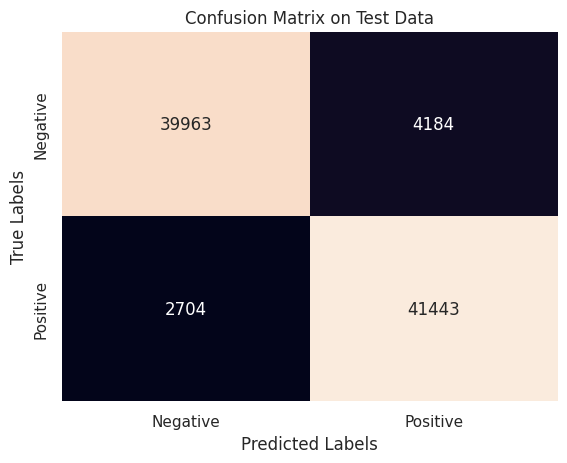

In [45]:
c_m = confusion_matrix(y_test_os, y_pred_os)
c_m_df = pd.DataFrame(c_m, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
sns.heatmap(c_m_df, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

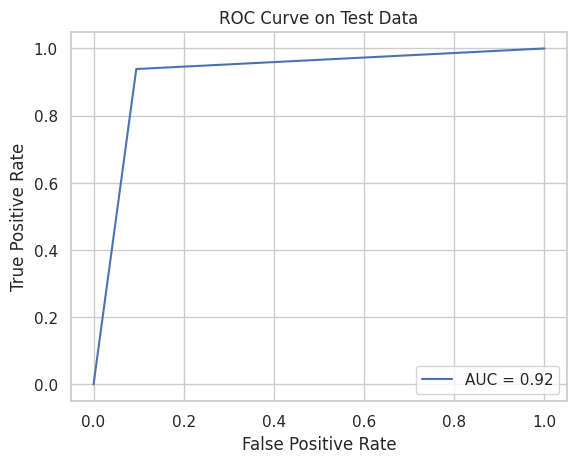

In [46]:
fpr, tpr, _ = roc_curve(y_test_os, y_pred_os)
score = roc_auc_score(y_test_os,y_pred_os)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=score)
display.plot()
plt.title("ROC Curve on Test Data")
plt.show() 

In [47]:
'''
rfc = RandomForestClassifier(random_state=42)

grid_space={'max_depth':[7, 15, 25, None],
            'n_estimators':[50, 100, 150, 200],
            'min_samples_split':[2, 4, 6],
            'min_samples_leaf':[1, 2, 3],
            'max_features':[2, 3, 4]
            }

grid = GridSearchCV(rfc, param_grid=grid_space, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_os,y_train_os)

params = grid.best_params_
print("Best Hyperparameters:", params)

model_final = grid.best_estimator_
y_pred_os = model_final.predict(X_test_os)
print_evaluation(y_test_os, y_pred_os)
'''

'\nrfc = RandomForestClassifier(random_state=42)\n\ngrid_space={\'max_depth\':[7, 15, 25, None],\n            \'n_estimators\':[50, 100, 150, 200],\n            \'min_samples_split\':[2, 4, 6],\n            \'min_samples_leaf\':[1, 2, 3],\n            \'max_features\':[2, 3, 4]\n            }\n\ngrid = GridSearchCV(rfc, param_grid=grid_space, cv=5, scoring=\'f1\', n_jobs=-1)\ngrid.fit(X_train_os,y_train_os)\n\nparams = grid.best_params_\nprint("Best Hyperparameters:", params)\n\nmodel_final = grid.best_estimator_\ny_pred_os = model_final.predict(X_test_os)\nprint_evaluation(y_test_os, y_pred_os)\n'

The final model is optimized using GridSearchCV for hyperparameter tuning.